In [1682]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from pykrx import stock
from pykrx import bond
from tqdm import tqdm

import equity_tools as eqt
import importlib
importlib.reload(eqt)

import warnings
warnings.filterwarnings(action='ignore')

multiple_fundamentals_mapping = {
    'PER':'EPS',
    'PBR':'BPS',
    'DY':'DPS'
}

https://github.com/sharebook-kr/pykrx \
https://expansion-of-thinking.tistory.com/16

In [1690]:
market_indices_summary = eqt.get_kr_market_indices_summary()

# subset major index and its components
summary_subset_df = market_indices_summary[market_indices_summary.index_name.isin(['코스피','코스닥'])]
summary_subset_df['index_components'] = summary_subset_df['code'].apply(lambda x: stock.get_index_portfolio_deposit_file(x))
summary_subset_df = summary_subset_df.set_index('code')

# sanity check
assert (summary_subset_df['종목수'] == summary_subset_df.index_components.apply(lambda x: len(x))).sum() == summary_subset_df.shape[0]

In [1692]:
# get index fundamentals historical data
to_date = pd.Timestamp.now().strftime('%Y%m%d')

index_fundamentals_list = []
for code in tqdm(summary_subset_df.index.tolist()):
    index_name = summary_subset_df.loc[code, 'index_name']
    from_date = summary_subset_df.loc[code, 'from_date']
    index_components = summary_subset_df.loc[code, 'index_components']
    print(index_name, from_date, to_date, code)
    index_fundamentals = stock.get_index_fundamental(from_date, to_date, code)
    index_fundamentals['index_name'] = index_name
    index_fundamentals_list.append(index_fundamentals)

# index summary into df
index_fundamentals_df = pd.concat(index_fundamentals_list, axis=0)
index_fundamentals_df = index_fundamentals_df.rename(columns={
    '종가': 'close',
    '등락률': 'change',
    '배당수익률': 'DY'
})

  0%|                                                     | 0/2 [00:00<?, ?it/s]

코스피 19800104 20250105 1001


 50%|██████████████████████▌                      | 1/2 [01:18<01:18, 78.16s/it]

코스닥 19960701 20250105 2001


100%|█████████████████████████████████████████████| 2/2 [02:05<00:00, 62.83s/it]


# KOSPI

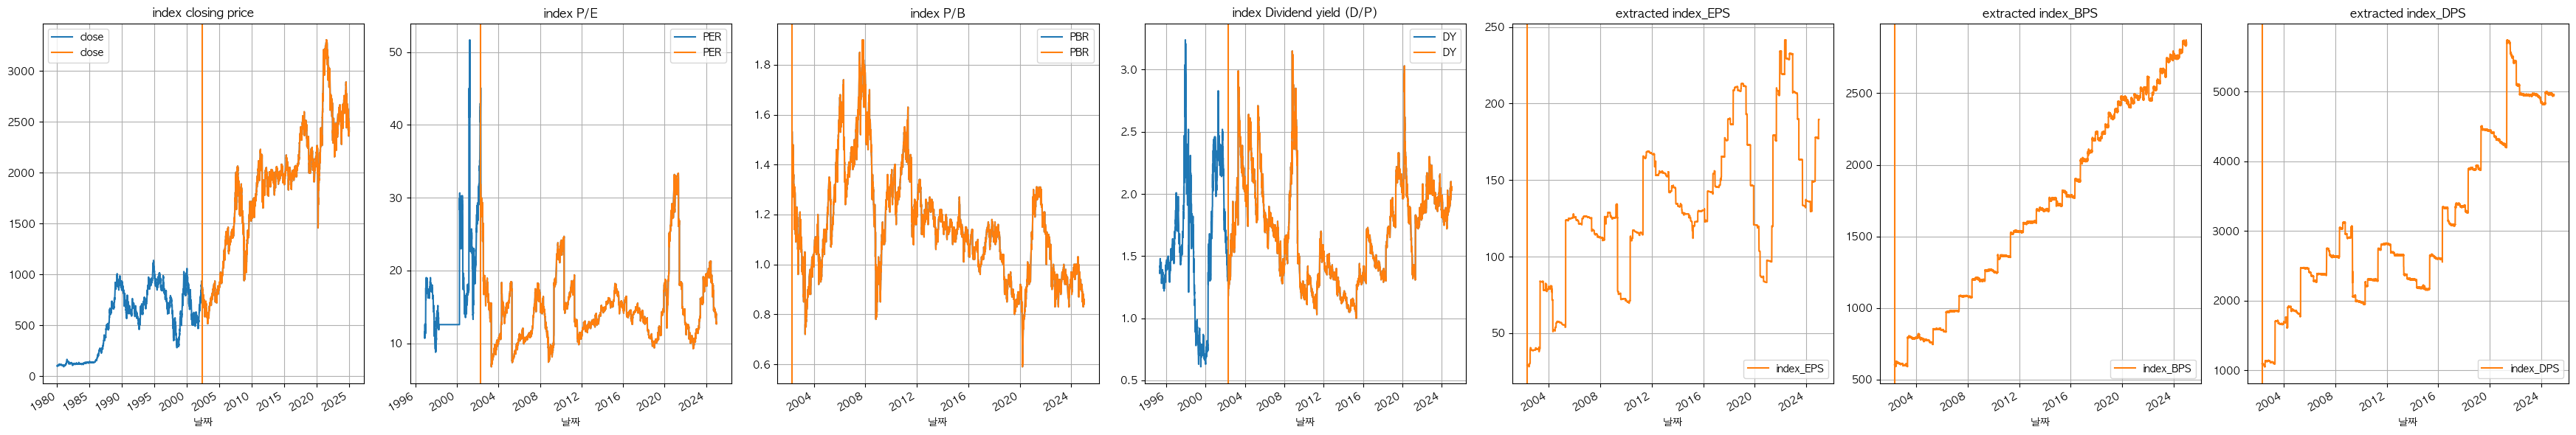

In [1774]:
chosen_index = index_fundamentals_df.query("`index_name` == '코스피'")
cleaned_index = eqt.clean_kr_index_data(chosen_index)
extracted_index_fundamentals = eqt.extract_kr_fundamental_values(cleaned_index)

fig,ax = plt.subplots(1,7, figsize=(35,6))
chosen_index['close'].plot(ax=ax[0], title='index closing price')
chosen_index['PER'].plot(ax=ax[1], title='index P/E')
chosen_index['PBR'].plot(ax=ax[2], title='index P/B')
chosen_index['DY'].plot(ax=ax[3], title='index Dividend yield (D/P)')

cleaned_index['close'].plot(ax=ax[0])
cleaned_index['PER'].plot(ax=ax[1])
cleaned_index['PBR'].plot(ax=ax[2])
cleaned_index['DY'].plot(ax=ax[3])

for i,v in enumerate(['EPS','BPS','DPS']): 
    extracted_index_fundamentals[v].plot(ax=ax[(i+4)], label=f'index_{v}', c='tab:orange', title=f'extracted index_{v}')

for i in range(len(ax)):
    ax[i].legend()
    ax[i].grid()
    ax[i].axvline(cleaned_index.index[0], label='non_zero_start', c='tab:orange')
plt.tight_layout();

Z-score for a (99.0%) two-tailed probability: 2.5758293035489004
Probability for Z-score (2.5758293035489004): 0.99


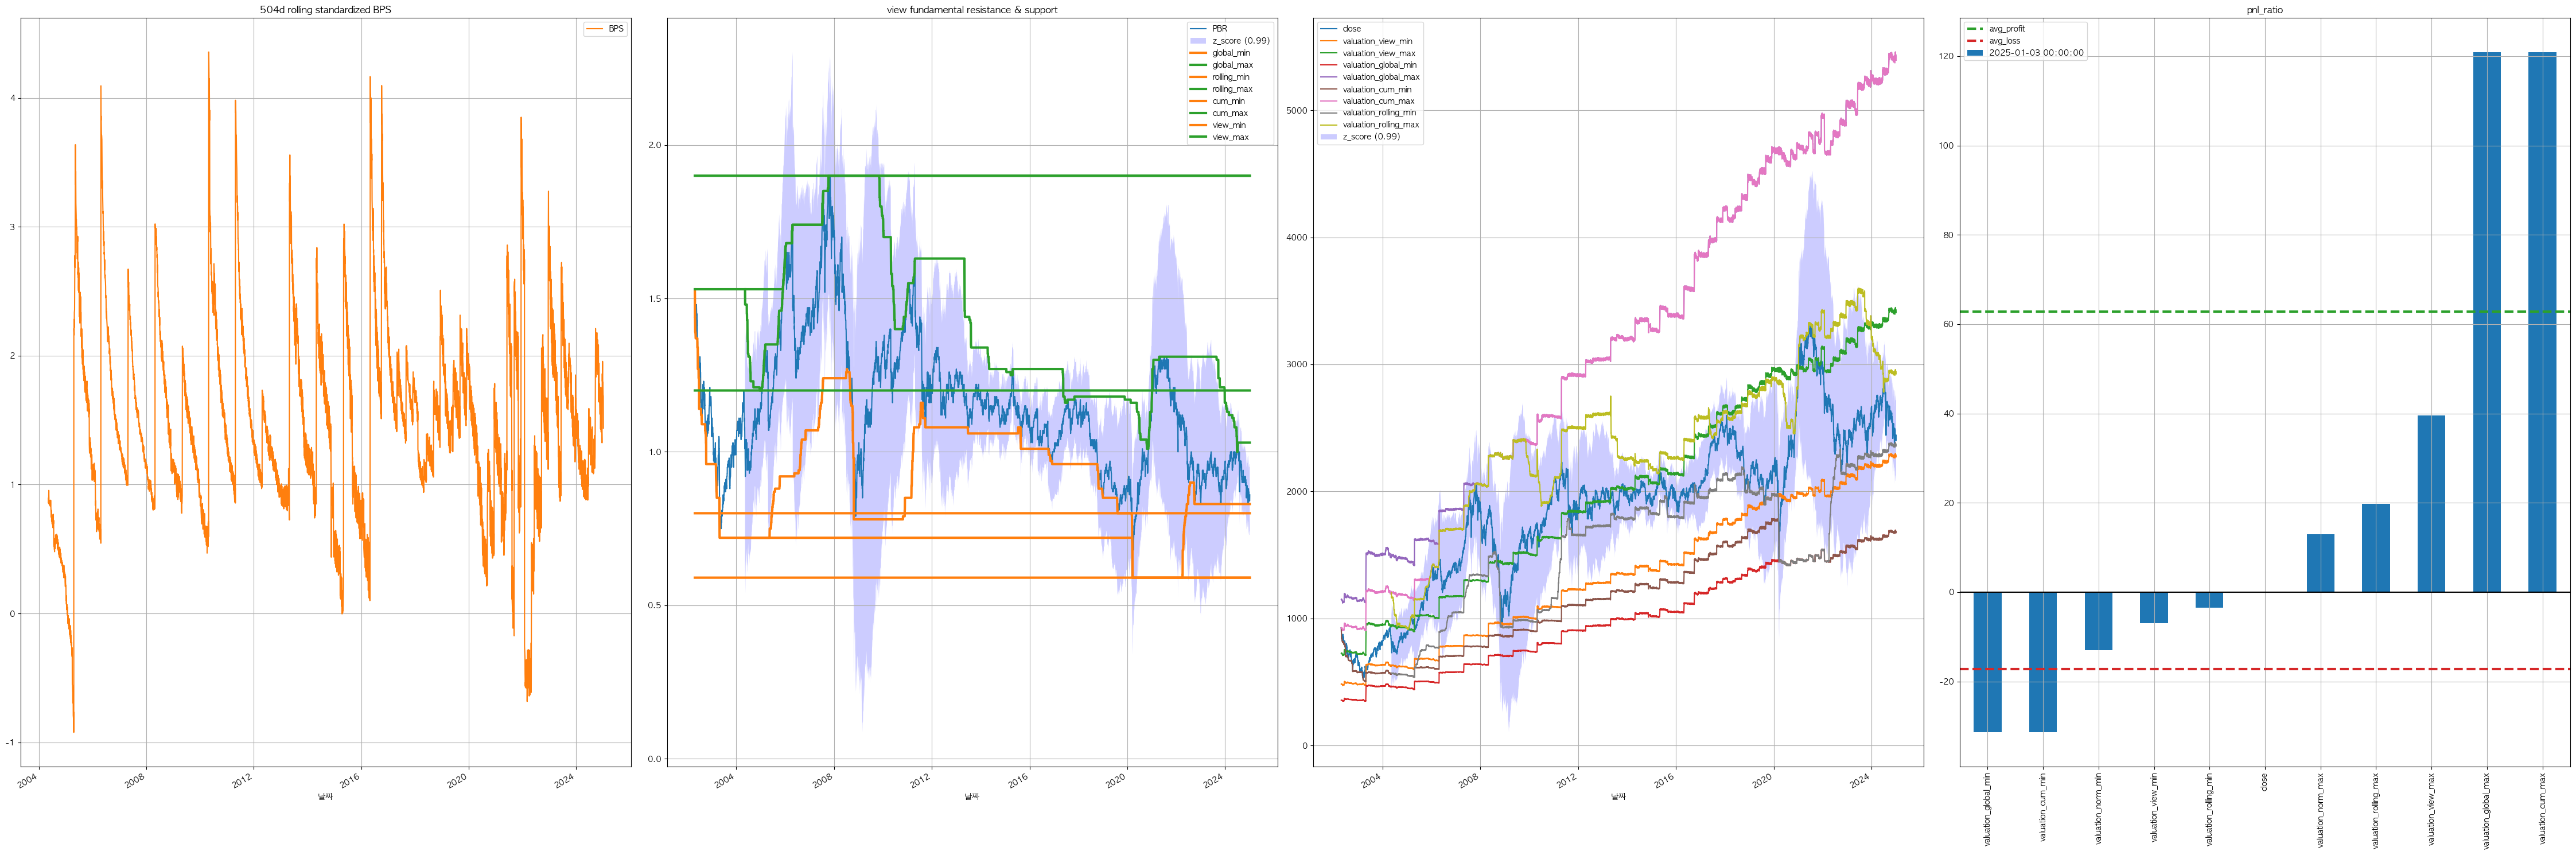

In [1775]:
multiple = 'PBR'
window = 252*2
view_min = 0.8
view_max = 1.2
confidence_level=0.99

index_valuation_df = pd.concat([
    cleaned_index['close'],
    cleaned_index[multiple].rename(multiple), 
    extracted_index_fundamentals[multiple_fundamentals_mapping[multiple]].rename(multiple_fundamentals_mapping[multiple])
], axis=1)

# generate minmax multiples
index_valuation_df = eqt.generate_kr_multiple_resistance_support(index_valuation_df, fundamental, view_min, view_max, 
                                                          window=window, confidence_level=confidence_level)



# pnl ratio
index_point_columns = ['close'] + index_valuation_df.filter(regex='valuation_.*').columns.tolist()
pnl_ratio = (index_valuation_df[index_point_columns].tail(1).T / index_valuation_df[index_point_columns].close[-1] - 1) * 100
avg_profit = pnl_ratio[pnl_ratio > 0].dropna().mean()
avg_loss = pnl_ratio[pnl_ratio < 0].dropna().mean()
ratio = avg_profit / abs(avg_loss)

# # plot
fig,ax = plt.subplots(1,4, figsize=(45,15))
index_valuation_df[multiple_fundamentals_mapping[multiple]].rolling(window=window).apply(eqt.standardize).plot(ax=ax[0], 
                                                                                                               label=f'{multiple_fundamentals_mapping[multiple]}', c='tab:orange', 
                                                                                                               title=f'{window}d rolling standardized {multiple_fundamentals_mapping[multiple]}')
index_valuation_df[multiple].plot(ax=ax[1])

bound_methods = set([col[:-4] for col in index_valuation_df.filter(regex='multiple_.*').columns.tolist()])
for name in bound_methods:
    method = name.split('_')[1]
    min_col = name + '_min'
    max_col = name + '_max'

    if method == 'norm':
        ax[1].fill_between(x=index_valuation_df.index, y1=index_valuation_df[min_col], y2=index_valuation_df[max_col], 
                           facecolor='b', alpha=0.2, label=f'z_score ({confidence_level})')
    else:
        index_valuation_df[min_col].plot(ax=ax[1], c='tab:orange', label=f'{method}_min', lw=3, title=f'{method} fundamental resistance & support')
        index_valuation_df[max_col].plot(ax=ax[1], c='tab:green', label=f'{method}_max', lw=3)

index_valuation_df[index_point_columns].drop(columns=index_valuation_df[index_point_columns].filter(regex='.*norm.*').columns).plot(ax=ax[2])
ax[2].fill_between(x=index_valuation_df.index,
                   y1=index_valuation_df[f'valuation_norm_min'], 
                   y2=index_valuation_df[f'valuation_norm_max'], 
                   facecolor='b', alpha=0.2, label=f'z_score ({confidence_level})')

pnl_ratio.squeeze().sort_values().plot(kind='bar', ax=ax[3], title='pnl_ratio')
ax[3].axhline(avg_profit.values, c='tab:green', label=f'avg_profit', ls='--', lw=3)
ax[3].axhline(avg_loss.values, c='tab:red', label=f'avg_loss', ls='--', lw=3)
ax[3].axhline(0, c='black')

for i in range(len(ax)):
    ax[i].legend()
    ax[i].grid()
plt.tight_layout();

In [1776]:
display(index_valuation_df.filter(regex='multiple_.*').tail(1).T.squeeze().sort_values().round(2).to_frame())
display(index_valuation_df[index_point_columns].tail(1).T.squeeze().sort_values().round(2).to_frame())
display(ratio)

,2025-01-03
multiple_global_min,0.59
multiple_cum_min,0.59
multiple_norm_min,0.75
multiple_view_min,0.80
multiple_rolling_min,0.83
multiple_norm_max,0.97
multiple_rolling_max,1.03
multiple_view_max,1.20
multiple_global_max,1.90
multiple_cum_max,1.90


,2025-01-03
valuation_global_min,1675.27
valuation_cum_min,1675.27
valuation_norm_min,2124.69
valuation_view_min,2271.55
valuation_rolling_min,2356.74
close,2441.92
valuation_norm_max,2759.15
valuation_rolling_max,2924.62
valuation_view_max,3407.33
valuation_global_max,5394.94


날짜
2025-01-03    3.642492
dtype: float64

# KOSDAQ

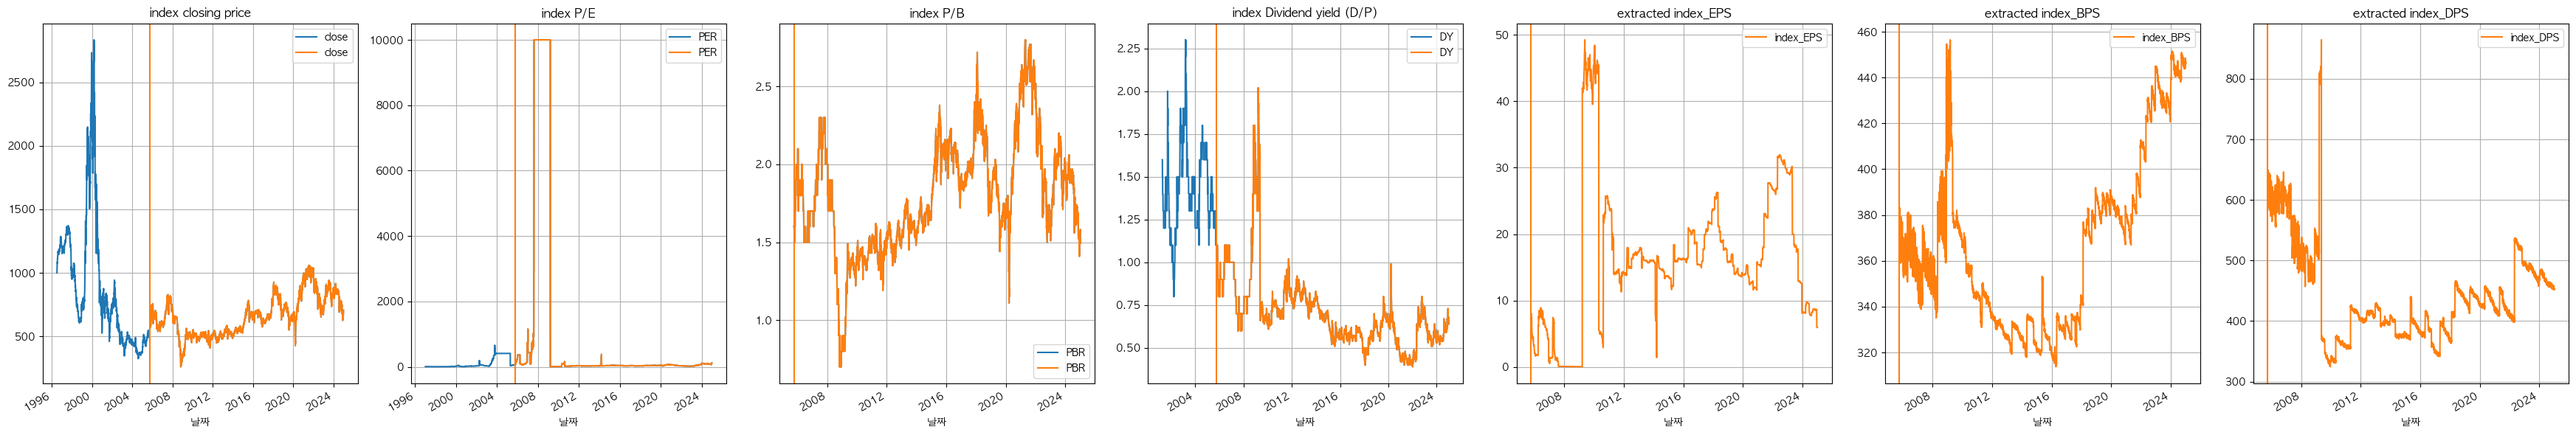

In [1778]:
chosen_index = index_fundamentals_df.query("`index_name` == '코스닥'")
cleaned_index = eqt.clean_kr_index_data(chosen_index)
extracted_index_fundamentals = eqt.extract_kr_fundamental_values(cleaned_index)

fig,ax = plt.subplots(1,7, figsize=(35,6))
chosen_index['close'].plot(ax=ax[0], title='index closing price')
chosen_index['PER'].plot(ax=ax[1], title='index P/E')
chosen_index['PBR'].plot(ax=ax[2], title='index P/B')
chosen_index['DY'].plot(ax=ax[3], title='index Dividend yield (D/P)')

cleaned_index['close'].plot(ax=ax[0])
cleaned_index['PER'].plot(ax=ax[1])
cleaned_index['PBR'].plot(ax=ax[2])
cleaned_index['DY'].plot(ax=ax[3])

for i,v in enumerate(['EPS','BPS','DPS']): 
    extracted_index_fundamentals[v].plot(ax=ax[(i+4)], label=f'index_{v}', c='tab:orange', title=f'extracted index_{v}')

for i in range(len(ax)):
    ax[i].legend()
    ax[i].grid()
    ax[i].axvline(cleaned_index.index[0], label='non_zero_start', c='tab:orange')
plt.tight_layout();

Z-score for a (99.0%) two-tailed probability: 2.5758293035489004
Probability for Z-score (2.5758293035489004): 0.99


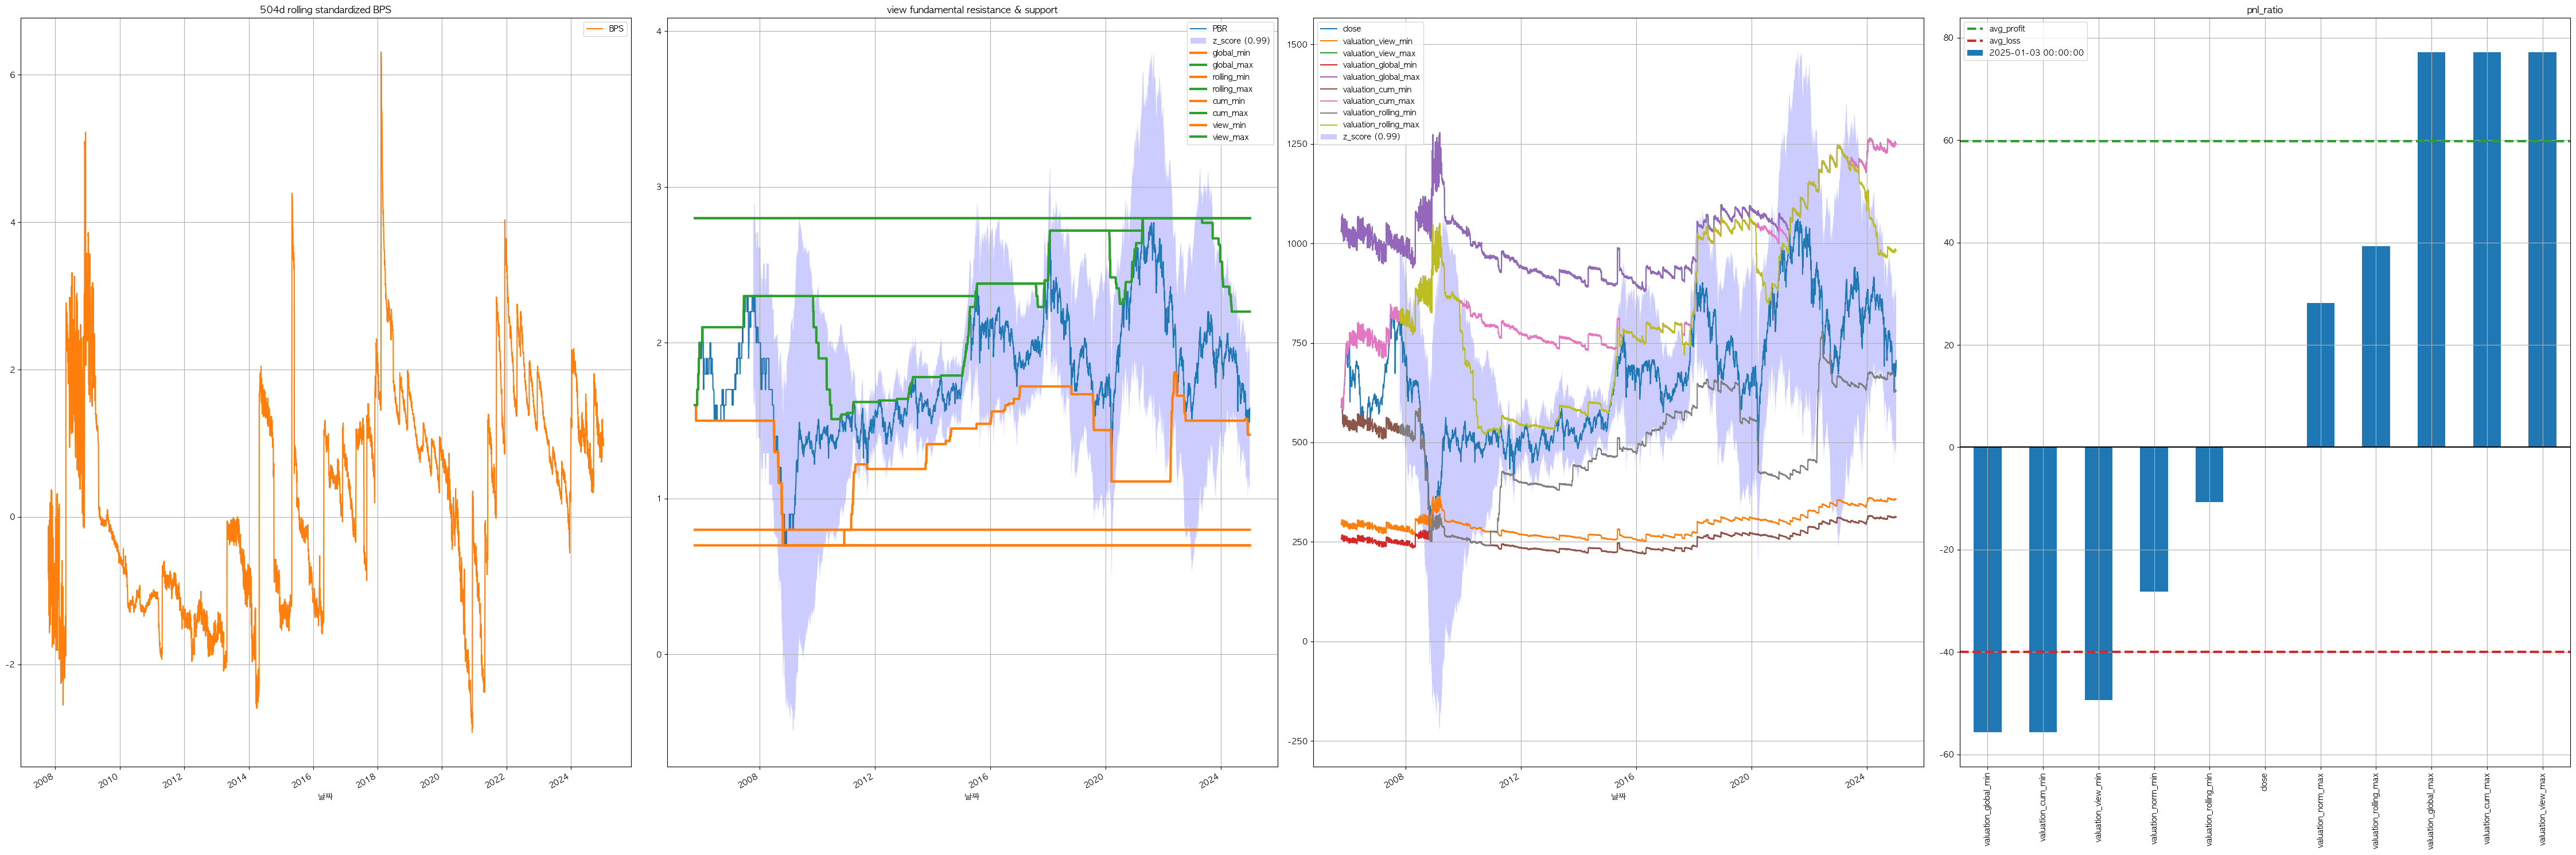

In [1779]:
multiple = 'PBR'
window = 252*2
view_min = 0.8
view_max = 2.8
confidence_level=0.99

index_valuation_df = pd.concat([
    cleaned_index['close'],
    cleaned_index[multiple].rename(multiple), 
    extracted_index_fundamentals[multiple_fundamentals_mapping[multiple]].rename(multiple_fundamentals_mapping[multiple])
], axis=1)

# generate minmax multiples
index_valuation_df = eqt.generate_kr_multiple_resistance_support(index_valuation_df, fundamental, view_min, view_max, 
                                                          window=window, confidence_level=confidence_level)



# pnl ratio
index_point_columns = ['close'] + index_valuation_df.filter(regex='valuation_.*').columns.tolist()
pnl_ratio = (index_valuation_df[index_point_columns].tail(1).T / index_valuation_df[index_point_columns].close[-1] - 1) * 100
avg_profit = pnl_ratio[pnl_ratio > 0].dropna().mean()
avg_loss = pnl_ratio[pnl_ratio < 0].dropna().mean()
ratio = avg_profit / abs(avg_loss)

# # plot
fig,ax = plt.subplots(1,4, figsize=(45,15))
index_valuation_df[multiple_fundamentals_mapping[multiple]].rolling(window=window).apply(eqt.standardize).plot(ax=ax[0], 
                                                                                                               label=f'{multiple_fundamentals_mapping[multiple]}', c='tab:orange', 
                                                                                                               title=f'{window}d rolling standardized {multiple_fundamentals_mapping[multiple]}')
index_valuation_df[multiple].plot(ax=ax[1])

bound_methods = set([col[:-4] for col in index_valuation_df.filter(regex='multiple_.*').columns.tolist()])
for name in bound_methods:
    method = name.split('_')[1]
    min_col = name + '_min'
    max_col = name + '_max'

    if method == 'norm':
        ax[1].fill_between(x=index_valuation_df.index, y1=index_valuation_df[min_col], y2=index_valuation_df[max_col], 
                           facecolor='b', alpha=0.2, label=f'z_score ({confidence_level})')
    else:
        index_valuation_df[min_col].plot(ax=ax[1], c='tab:orange', label=f'{method}_min', lw=3, title=f'{method} fundamental resistance & support')
        index_valuation_df[max_col].plot(ax=ax[1], c='tab:green', label=f'{method}_max', lw=3)

index_valuation_df[index_point_columns].drop(columns=index_valuation_df[index_point_columns].filter(regex='.*norm.*').columns).plot(ax=ax[2])
ax[2].fill_between(x=index_valuation_df.index,
                   y1=index_valuation_df[f'valuation_norm_min'], 
                   y2=index_valuation_df[f'valuation_norm_max'], 
                   facecolor='b', alpha=0.2, label=f'z_score ({confidence_level})')

pnl_ratio.squeeze().sort_values().plot(kind='bar', ax=ax[3], title='pnl_ratio')
ax[3].axhline(avg_profit.values, c='tab:green', label=f'avg_profit', ls='--', lw=3)
ax[3].axhline(avg_loss.values, c='tab:red', label=f'avg_loss', ls='--', lw=3)
ax[3].axhline(0, c='black')

for i in range(len(ax)):
    ax[i].legend()
    ax[i].grid()
plt.tight_layout();

In [1780]:
display(index_valuation_df.filter(regex='multiple_.*').tail(1).T.squeeze().sort_values().round(2).to_frame())
display(index_valuation_df[index_point_columns].tail(1).T.squeeze().sort_values().round(2).to_frame())
display(ratio)

,2025-01-03
multiple_global_min,0.70
multiple_cum_min,0.70
multiple_view_min,0.80
multiple_norm_min,1.13
multiple_rolling_min,1.41
multiple_norm_max,2.03
multiple_rolling_max,2.20
multiple_global_max,2.80
multiple_cum_max,2.80
multiple_view_max,2.80


,2025-01-03
valuation_global_min,312.68
valuation_cum_min,312.68
valuation_view_min,357.35
valuation_norm_min,506.65
valuation_rolling_min,629.82
close,705.76
valuation_norm_max,904.87
valuation_rolling_max,982.70
valuation_global_max,1250.71
valuation_cum_max,1250.71


날짜
2025-01-03    1.497504
dtype: float64